# **1. Tải dữ liệu từ nền tảng Kaggle**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import zipfile
os.makedirs("/root/.kaggle", exist_ok=True)
!cp /content/drive/MyDrive/kaggle/kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Tải dataset
!kaggle datasets download -d antonkozyriev/game-recommendations-on-steam

# Giải nén
with zipfile.ZipFile("game-recommendations-on-steam.zip", 'r') as zip_ref:
    zip_ref.extractall("steam_data")

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam
License(s): CC0-1.0
 98% 649M/660M [00:03<00:00, 48.3MB/s]
100% 660M/660M [00:03<00:00, 177MB/s] 


# **2. Khai báo các thư viện sử dụng**

In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# **3. Tổng quan về bộ dữ liệu**

In [3]:
games_df = pd.read_csv(
    "steam_data/games.csv",
    usecols = ["app_id", "title", "date_release", "rating", "positive_ratio", "user_reviews", "price_final"],
    parse_dates = ["date_release"]
)

recom_df = pd.read_csv(
    "steam_data/recommendations.csv",
    usecols=["app_id", "date", "is_recommended", "hours", "user_id", "review_id"],
    parse_dates = ["date"]
)

# **4. Phân tích khám phá dữ liệu (EDA)**

## **4.1. Phát hiện giá trị thiếu**



In [ ]:
print("Kiểm tra giá trị thiếu ở games_df")
print(games_df.isnull().any())

print("\nKiểm tra giá trị thiếu ở recom_df")
print(recom_df.isnull().any())

Kiểm tra giá trị thiếu ở games_df
app_id            False
title             False
date_release      False
rating            False
positive_ratio    False
user_reviews      False
price_final       False
dtype: bool

Kiểm tra giá trị thiếu ở recom_df
app_id            False
helpful           False
funny             False
date              False
is_recommended    False
hours             False
user_id           False
review_id         False
dtype: bool


## **4.2. Trực quan hoá phân phối dữ liệu**

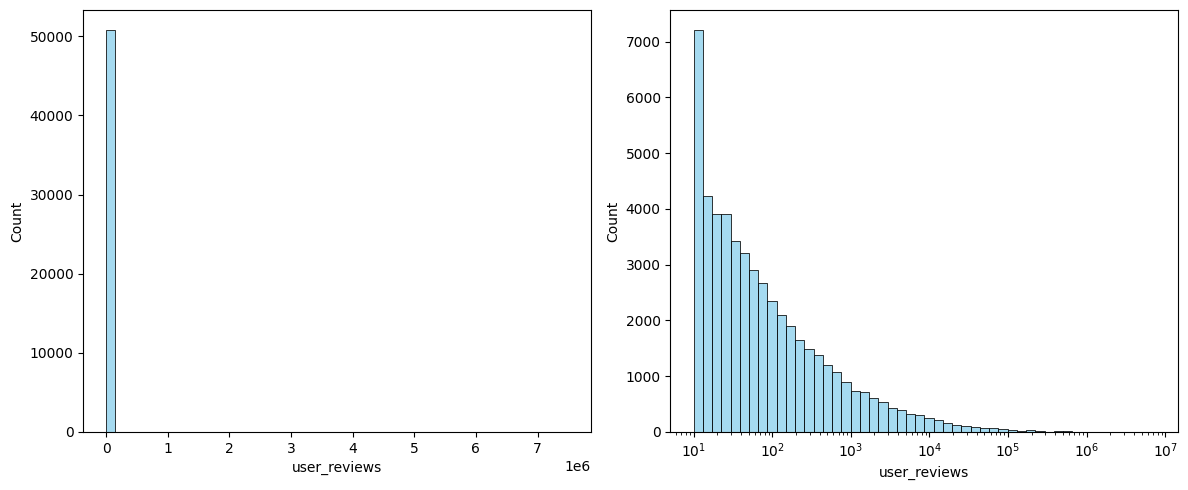

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.histplot(games_df['user_reviews'], bins=50, color='skyblue')

plt.subplot(1, 2, 2)
sns.histplot(games_df['user_reviews'], bins=50, color='skyblue', log_scale=(True, False))

plt.tight_layout()
plt.show()

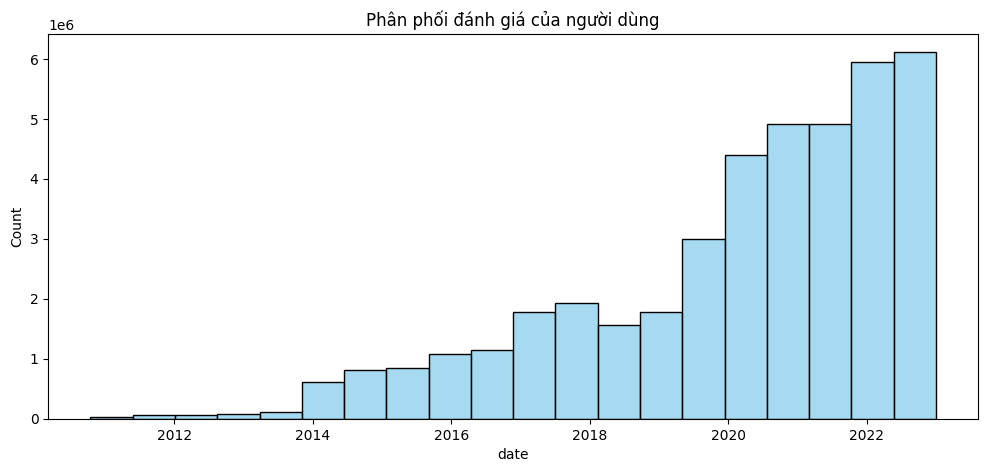

In [ ]:
plt.figure(figsize=(12,5))
sns.histplot(recom_df['date'], bins=20, color='skyblue')
plt.title("Phân phối đánh giá của người dùng")
plt.show()

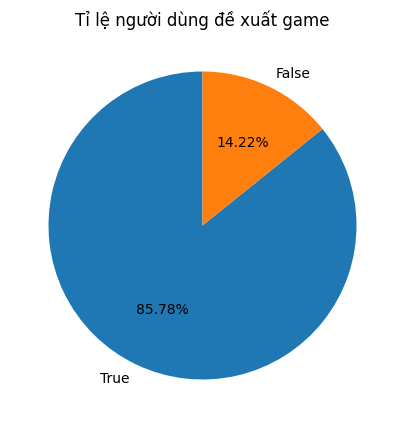

In [ ]:
plt.figure(figsize=(10,5))
plt.pie(recom_df['is_recommended'].value_counts(), labels=['True', 'False'], autopct='%1.2f%%', startangle=90)
plt.title("Tỉ lệ người dùng đề xuất game")
plt.show()

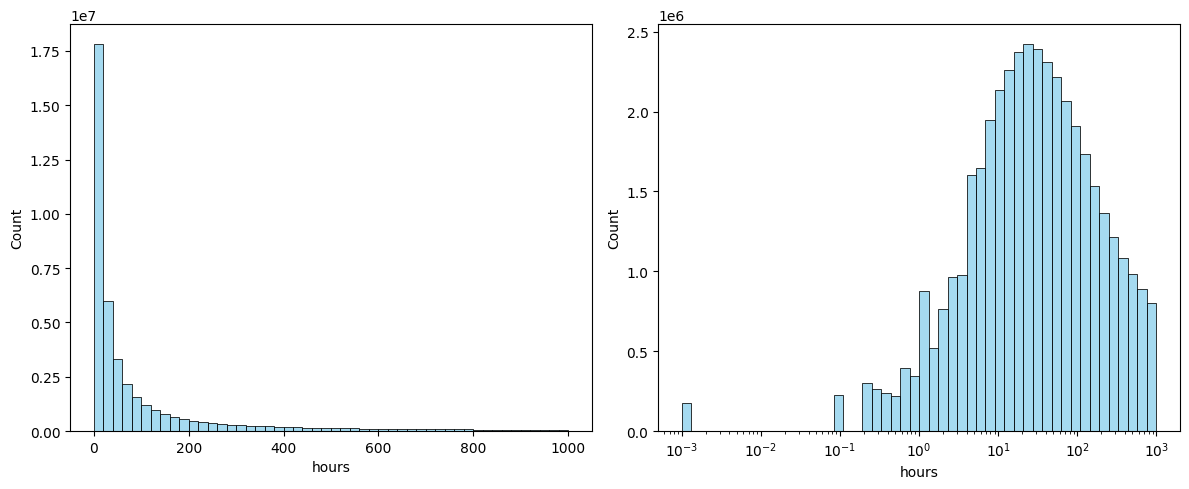

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(1e-3 + recom_df['hours'], bins=50, color='skyblue')

plt.subplot(1, 2, 2)
sns.histplot(1e-3 + recom_df['hours'], bins=50, color='skyblue',log_scale = (True, False))

plt.tight_layout()
plt.show()

## **4.3. Phát hiện ngoại lai**

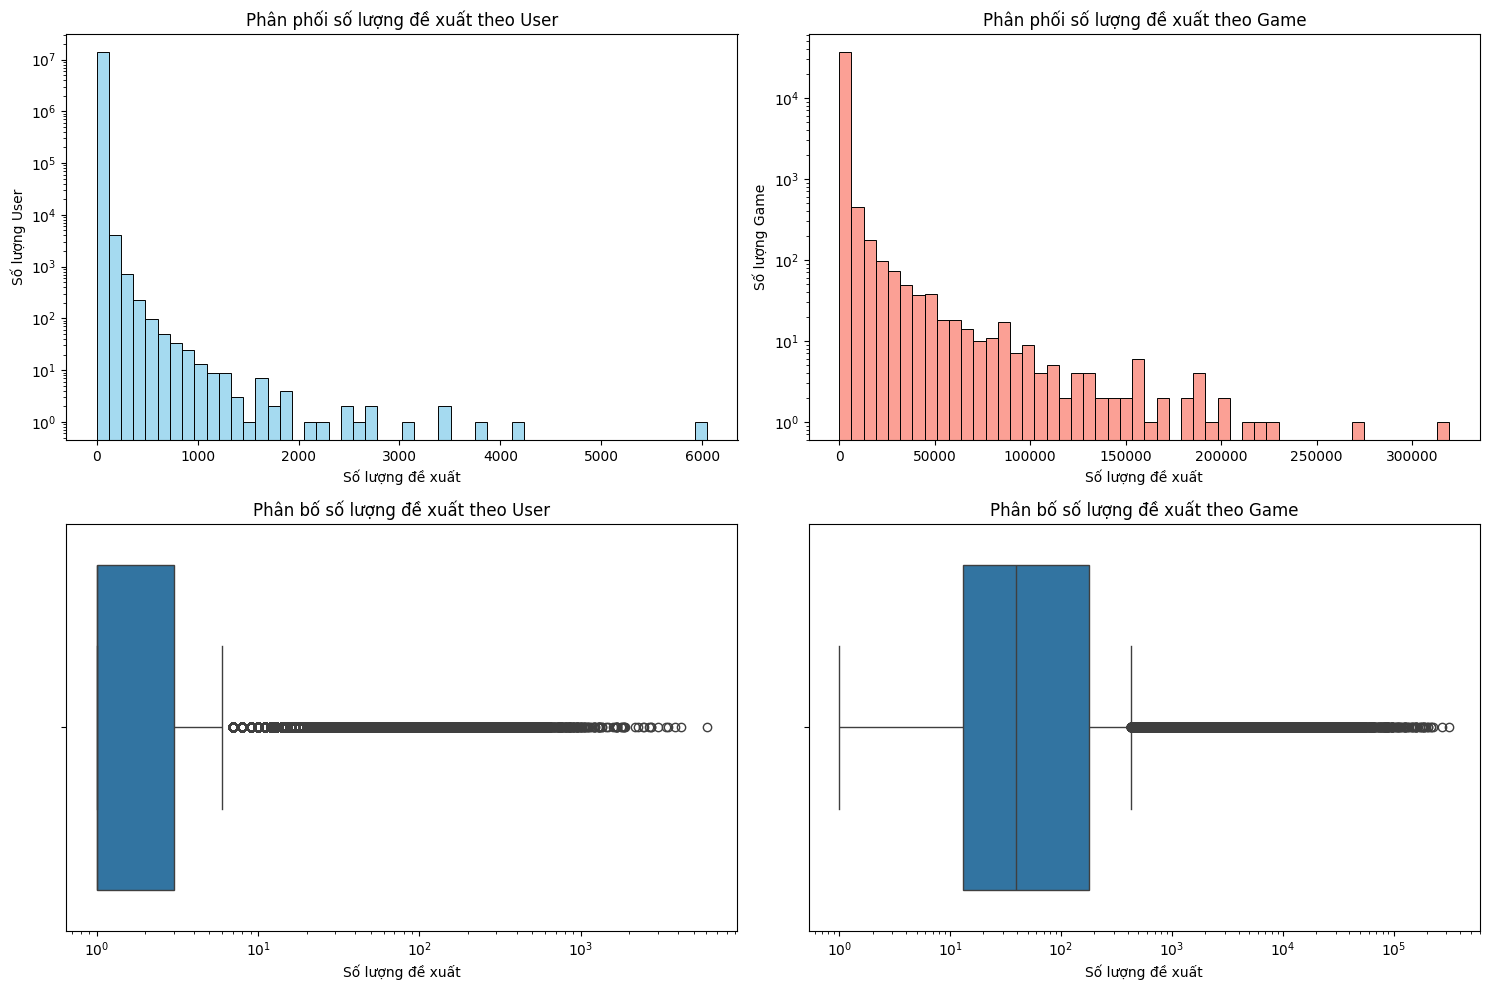

In [ ]:
# Calculate the number of recommendations per user and game
user_recommendation_counts = recom_df['user_id'].value_counts()
game_recommendation_counts = recom_df['app_id'].value_counts()

# Tạo bố cục 2 hàng, 2 cột
plt.figure(figsize=(15, 10))

# Histogram cho User
plt.subplot(2, 2, 1)
sns.histplot(user_recommendation_counts, bins=50, color='skyblue')
plt.title('Phân phối số lượng đề xuất theo User')
plt.xlabel('Số lượng đề xuất')
plt.ylabel('Số lượng User')
plt.yscale('log')

# Histogram cho Game
plt.subplot(2, 2, 2)
sns.histplot(game_recommendation_counts, bins=50, color='salmon')
plt.title('Phân phối số lượng đề xuất theo Game')
plt.xlabel('Số lượng đề xuất')
plt.ylabel('Số lượng Game')
plt.yscale('log')

# Box plot cho User (nằm ngang)
plt.subplot(2, 2, 3)
sns.boxplot(x=user_recommendation_counts, orient="h")
plt.title('Phân bố số lượng đề xuất theo User')
plt.xlabel('Số lượng đề xuất')
plt.xscale('log')

# Box plot cho Game (nằm ngang)
plt.subplot(2, 2, 4)
sns.boxplot(x=game_recommendation_counts, orient="h")
plt.title('Phân bố số lượng đề xuất theo Game')
plt.xlabel('Số lượng đề xuất')
plt.xscale('log')

# Điều chỉnh khoảng cách giữa các subplot
plt.tight_layout()
plt.show()

# **5. Chuẩn bị dữ liệu**

## **5.1. Lọc dữ liệu để giảm kích thước**

In [4]:
# Lọc game
print("Lọc game")
filtered_games_df = games_df[
    (games_df["user_reviews"] >= 1000) &
    (games_df["date_release"].dt.year >= 2009) &
    (games_df["date_release"].dt.year <= 2023)
]

Lọc game


In [5]:
# Lọc recommendations từ pre-release
print("Lọc recommendations từ pre-release")
filtered_recom_df = recom_df[recom_df["app_id"].isin(filtered_games_df["app_id"])].copy()
release_dates = filtered_games_df.set_index("app_id")["date_release"]
filtered_recom_df.loc[:, "release_date"] = filtered_recom_df["app_id"].map(release_dates)
filtered_recom_df = filtered_recom_df[filtered_recom_df["date"] >= filtered_recom_df["release_date"]]

Lọc recommendations từ pre-release


In [6]:
# Lọc user có >= 30 feedback
print("Lọc user có >= 30 feedback")
user_counts = filtered_recom_df["user_id"].value_counts()
valid_users = user_counts[user_counts >= 30].index
filtered_recom_df = filtered_recom_df[filtered_recom_df["user_id"].isin(valid_users)]

Lọc user có >= 30 feedback


## **5.2. Làm sạch dữ liệu và biến đổi dữ liệu**

In [8]:
# Loại bỏ dữ liệu trùng lặp
filtered_games_df = filtered_games_df.drop_duplicates(keep='first')
filtered_recom_df = filtered_recom_df.drop_duplicates(keep='first')

# Loại bỏ dữ liệu không có tương tác
filtered_game_id_set = set(filtered_games_df['app_id'])
filtered_recom_df = filtered_recom_df[filtered_recom_df["app_id"].isin(filtered_game_id_set)]

filtered_recom_id_set = set(filtered_recom_df['app_id'])
filtered_games_df = filtered_games_df[filtered_games_df['app_id'].isin(filtered_recom_id_set)]

# Biến đối dữ liệu
filtered_recom_df["hours_log"] = np.log10(1 + filtered_recom_df["hours"])
filtered_recom_df["is_recommended"] = filtered_recom_df["is_recommended"].astype(int)

## **5.3. Lọc dữ liệu cho tập train/test**

In [9]:
# Lọc user theo điều kiện pos/neg
print("Lọc user theo điều kiện pos/neg")
filtered_recom_df = filtered_recom_df.sort_values("date").reset_index(drop=True)

start_date = filtered_recom_df["date"].min()
end_date = filtered_recom_df["date"].max()
pivot_date = start_date + (end_date - start_date) * 0.918

print(f"Ngày bắt đầu: {start_date}")
print(f"Ngày kết thúc: {end_date}")
print(f"Mốc chia: {pivot_date}")

train_df = filtered_recom_df[filtered_recom_df["date"] < pivot_date].copy()
test_df = filtered_recom_df[filtered_recom_df["date"] >= pivot_date].copy()

valid_users = []

for user_id in filtered_recom_df["user_id"].unique():
    user_train = train_df[train_df["user_id"] == user_id]
    user_test = test_df[test_df["user_id"] == user_id]

    has_pos_train = (user_train["is_recommended"] == 1).any()
    has_neg_train = (user_train["is_recommended"] == 0).any()
    has_pos_test = (user_test["is_recommended"] == 1).any()

    if has_pos_train and has_neg_train and has_pos_test:
        valid_users.append(user_id)

train_df = train_df[train_df["user_id"].isin(valid_users)].reset_index(drop=True)
test_df = test_df[test_df["user_id"].isin(valid_users)].reset_index(drop=True)
filtered_recom_df = filtered_recom_df[filtered_recom_df["user_id"].isin(valid_users)].reset_index(drop=True)

Lọc user theo điều kiện pos/neg
Ngày bắt đầu: 2010-10-15 00:00:00
Ngày kết thúc: 2022-12-31 00:00:00
Mốc chia: 2021-12-30 06:43:12


In [10]:
# In số lượng còn lại
print(f"Số user: {filtered_recom_df['user_id'].nunique()}")
print(f"Số game: {filtered_recom_df['app_id'].nunique()}")
print(f"Số recommendation: {len(filtered_recom_df)}")
print(f"Tỉ lệ train/test: {len(train_df)}/{len(test_df)} ({len(train_df) / len(filtered_recom_df) * 100}%)")

Số user: 47274
Số game: 4632
Số recommendation: 2535036
Tỉ lệ train/test: 2057155/477881 (81.14894620825898%)


In [11]:
# Mô tả số lượng pos, neg, tỉ lệ trong train
train_stats = train_df.groupby(["user_id", "is_recommended"]).size().unstack(fill_value=0)

train_stats.columns = ["Negative", "Positive"] if 0 in train_stats.columns else train_stats.columns
train_stats["Ratio_Positive"] = train_stats["Positive"] / train_stats["Negative"]

print("Describe số lượng Positive trong tập train:")
print(train_stats["Positive"].describe())

print("\nDescribe số lượng Negative trong tập train:")
print(train_stats["Negative"].describe())

print("\nDescribe tỷ lệ Positive trong tập train:")
print(train_stats["Ratio_Positive"].describe())

Describe số lượng Positive trong tập train:
count    47274.000000
mean        35.516880
std         27.872952
min          1.000000
25%         22.000000
50%         29.000000
75%         40.000000
max        946.000000
Name: Positive, dtype: float64

Describe số lượng Negative trong tập train:
count    47274.000000
mean         7.998688
std         12.335314
min          1.000000
25%          2.000000
50%          5.000000
75%         10.000000
max        739.000000
Name: Negative, dtype: float64

Describe tỷ lệ Positive trong tập train:
count    47274.000000
mean        10.424410
std         12.849369
min          0.023810
25%          3.000000
50%          6.000000
75%         13.000000
max        514.000000
Name: Ratio_Positive, dtype: float64


## **5.4. Kiểm tra quá trình lọc dữ liệu cho tập train/test**

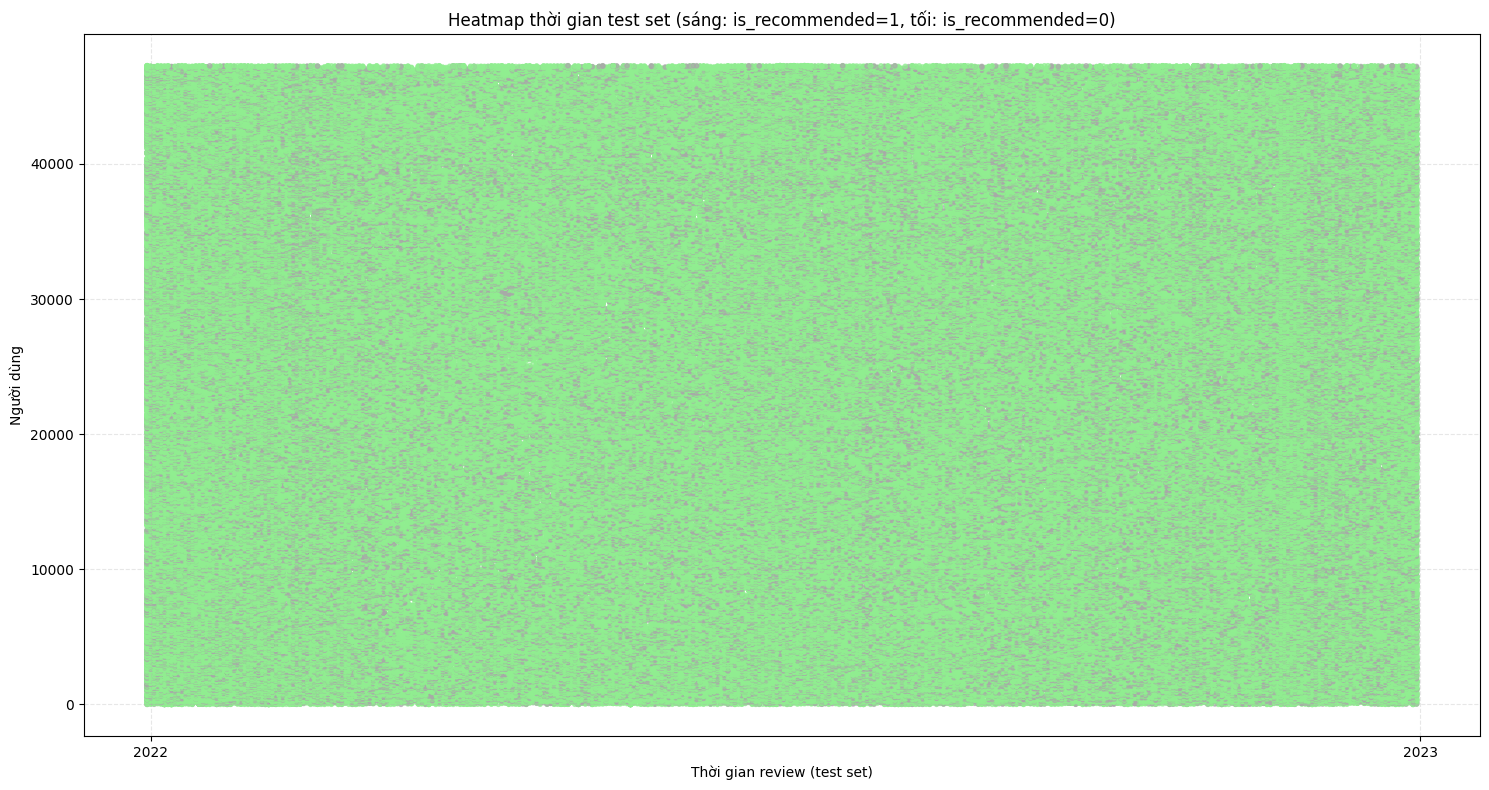

In [12]:
test_df_sorted = test_df.sort_values(["user_id", "date"]).reset_index(drop=True)
# Vẽ scatter plot theo thời gian trong tập test
user_id_to_index = {uid: idx for idx, uid in enumerate(test_df_sorted["user_id"].unique())}
test_df_sorted["user_index"] = test_df_sorted["user_id"].map(user_id_to_index)

plt.figure(figsize=(15, 8))
colors = test_df_sorted["is_recommended"].map({1: "lightgreen", 0: "darkgray"})

plt.scatter(
    test_df_sorted["date"],
    test_df_sorted["user_index"],
    c=colors,
    s=10,
    alpha=0.7
)

plt.xlabel("Thời gian review (test set)")
plt.ylabel("Người dùng")
plt.title("Heatmap thời gian test set (sáng: is_recommended=1, tối: is_recommended=0)")
plt.grid(True, linestyle="--", alpha=0.3)

# Format trục thời gian
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.tight_layout()
plt.show()

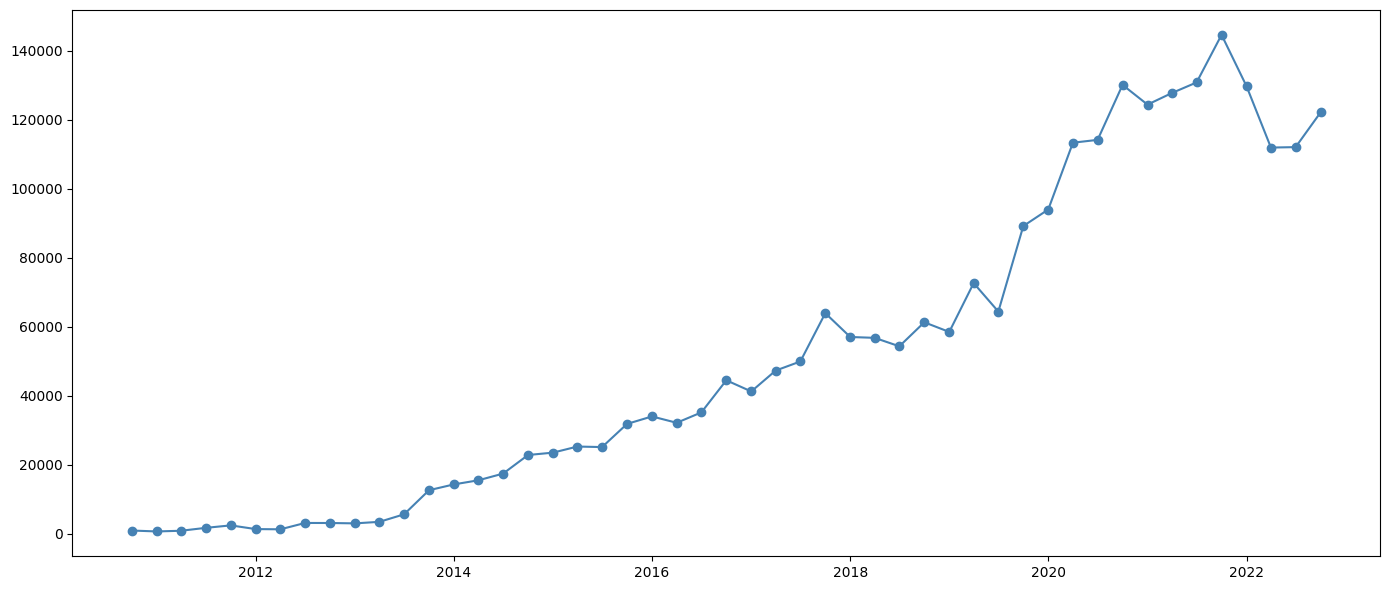

In [13]:
# Phân bố số recommendation theo thời gian (tính theo quý)
df = pd.concat([train_df, test_df])
df["quarter"] = df["date"].dt.to_period("Q").dt.to_timestamp()
review_counts = df.groupby("quarter").size()

plt.figure(figsize=(14, 6))
plt.plot(review_counts.index, review_counts.values, marker="o", linestyle="-", color="steelblue")
plt.tight_layout()
plt.show()

## **5.5. Lưu dữ liệu**

In [14]:
# Define the directory path
save_directory = "/content/drive/MyDrive/Project II/data/"

# Create the directory if it doesn't exist
os.makedirs(save_directory, exist_ok=True)

# Lưu
filtered_games_df = games_df[games_df["app_id"].isin(filtered_recom_df["app_id"].unique())]

# Save the dataframes to the specified directory
filtered_recom_df.to_csv(os.path.join(save_directory, "recommendations_processed.csv"), index=False)
filtered_games_df.to_csv(os.path.join(save_directory, "games_processed.csv"), index=False)
print("Đã lưu thành công")

Đã lưu thành công
